# Correct PINNs Prediction with FEM and $\phi$-FEM

## Imports

In [1]:
from scar.problem.Case import *
from scar.equations.Poisson2D import *
from scar.utils import read_config,create_tree
from scar.equations.run_Poisson2D import *

from scar.solver.solver_fem import *
from scar.solver.solver_phifem import *
from scar.correction.correct_pred import *

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Define case

In [2]:
casefile = "case.json"
config = 1
type = 0 # help="0 - all ; 1 - add ; 2 - add IPP ; 3 - mult"

In [3]:
cas = Case("../testcases/"+casefile)

problem_considered = cas.problem
pde_considered = cas.pde

dir_name = "../"+cas.dir_name
models_dir = dir_name+"models/"
corr_type = cas.corr_type
corr_dir = "../"+cas.corr_dir_name
create_tree(corr_dir)

## Récupération du modèle

### Config file :  ../networks/Poisson2D/Circle/SDCircle/WSolOnCircle/-0.1/models/config_1.json
### Model file :  ../networks/Poisson2D/Circle/SDCircle/WSolOnCircle/-0.1/models/model_1.pth
### Config  1  :  {'casefile': 'case.json', 'layers': [20, 20, 20, 20], 'activation': 'sine', 'lr': [0.01], 'decay': 0.99, 'w_data': 0.0, 'w_res': 1.0, 'n_epochs': 10000, 'n_collocations': 2000, 'n_data': 0}
Threshold of the sampling:  -0.1
Threshold of the sampling:  -0.1
Threshold of the sampling:  -0.1
Threshold of the sampling:  -0.1
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Circle/SDCircle/WSolOnCircle/-0.1/models/model_1.pth


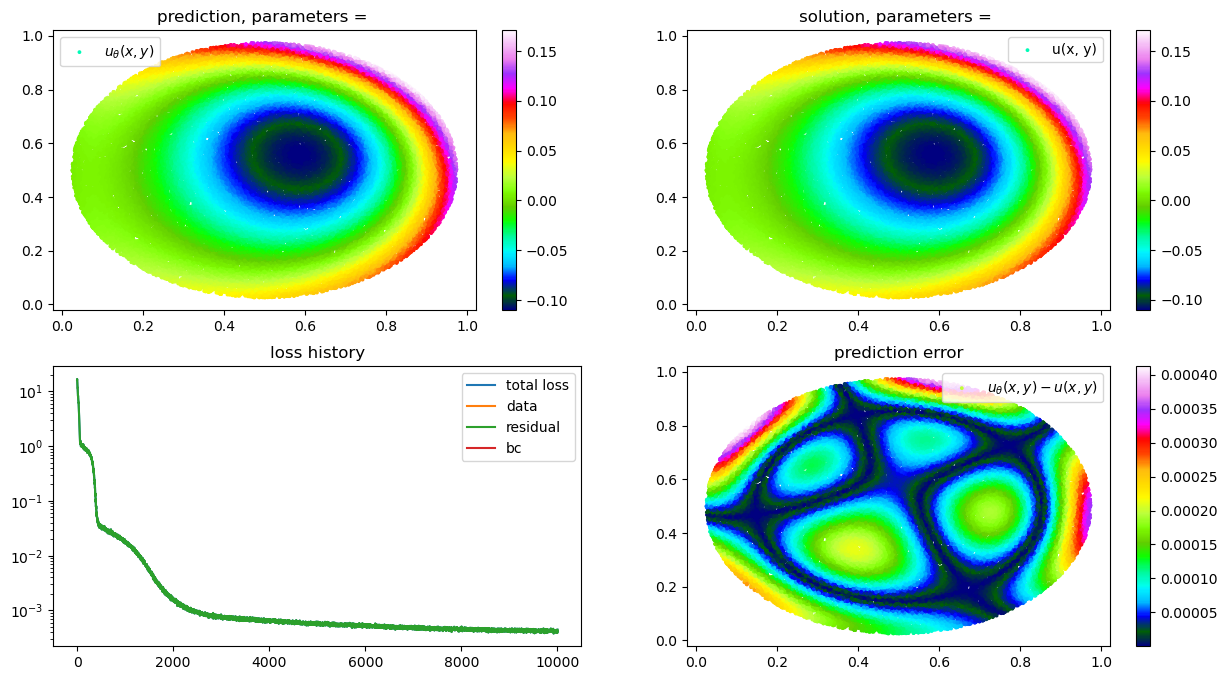

In [4]:
config_filename = models_dir+"config_"+str(config)+".json"
model_filename = models_dir+"model_"+str(config)+".pth"
print("### Config file : ",config_filename)
print("### Model file : ",model_filename)

dict = read_config(config_filename)
print("### Config ", config, " : ", dict)

trainer = run_Poisson2D(cas,config,dict)

## Correction

In [5]:
if trainer.pde.nb_parameters == 0:
    params = [[None,None,None]]
else:
    mu = torch.mean(trainer.pde.parameter_domain, axis=1)
    S,f,p = mu.numpy()
    params = [[S,f,p]]

nb_vert = 32
deg_corr = 10

### Avec FEM

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


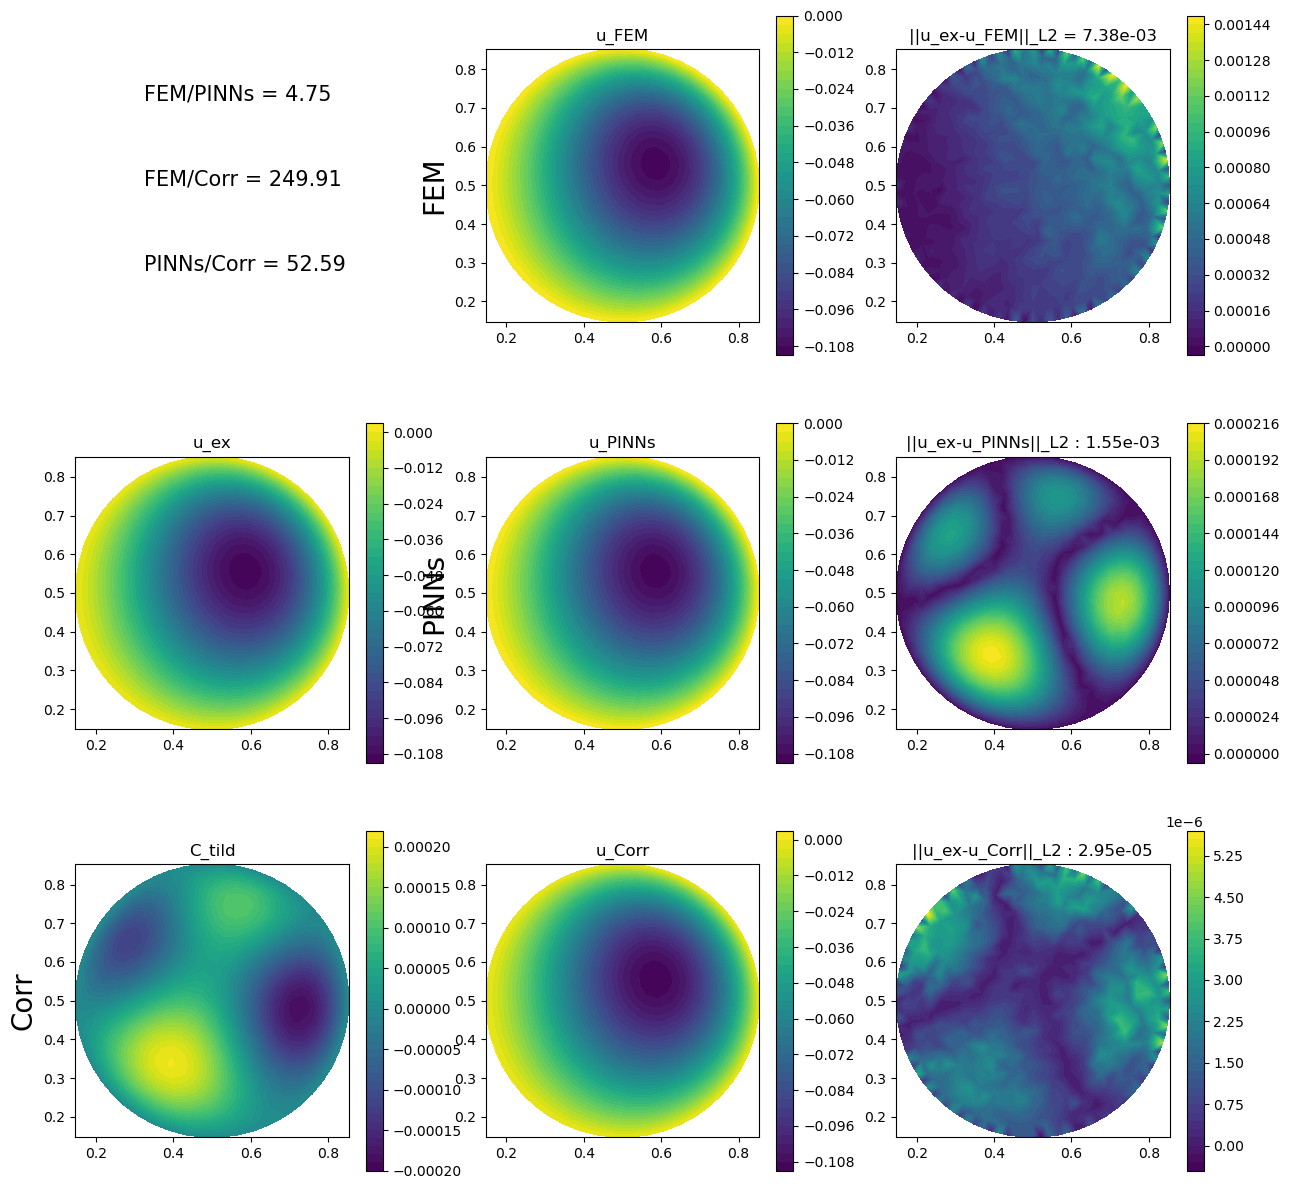

In [6]:
solver = FEMSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get differents solutions
u_ex = UexExpr(solver.params[0], degree=deg_corr, domain=solver.mesh, pb_considered=solver.pb_considered)
u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr, get_error=True)
u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type)
u_FEM,norm_L2_FEM = solver.fem(0)

# plot
u_ex = project(u_ex, solver.V)

solutions = [u_PINNs,u_Corr,u_FEM]
normes = [norm_L2_PINNs,norm_L2_Corr,norm_L2_FEM]

plot_sol(corr_dir,config,"FEM",u_ex,C,solutions,normes,solver.V)

### Avec PhiFEM

num of cell in the ghost penalty: 150
Building point search tree to accelerate distance queries.
Computed bounding box tree with 2027 nodes for 1014 points.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
### Correction par addition avec PhiFEM - Projection sur Omega


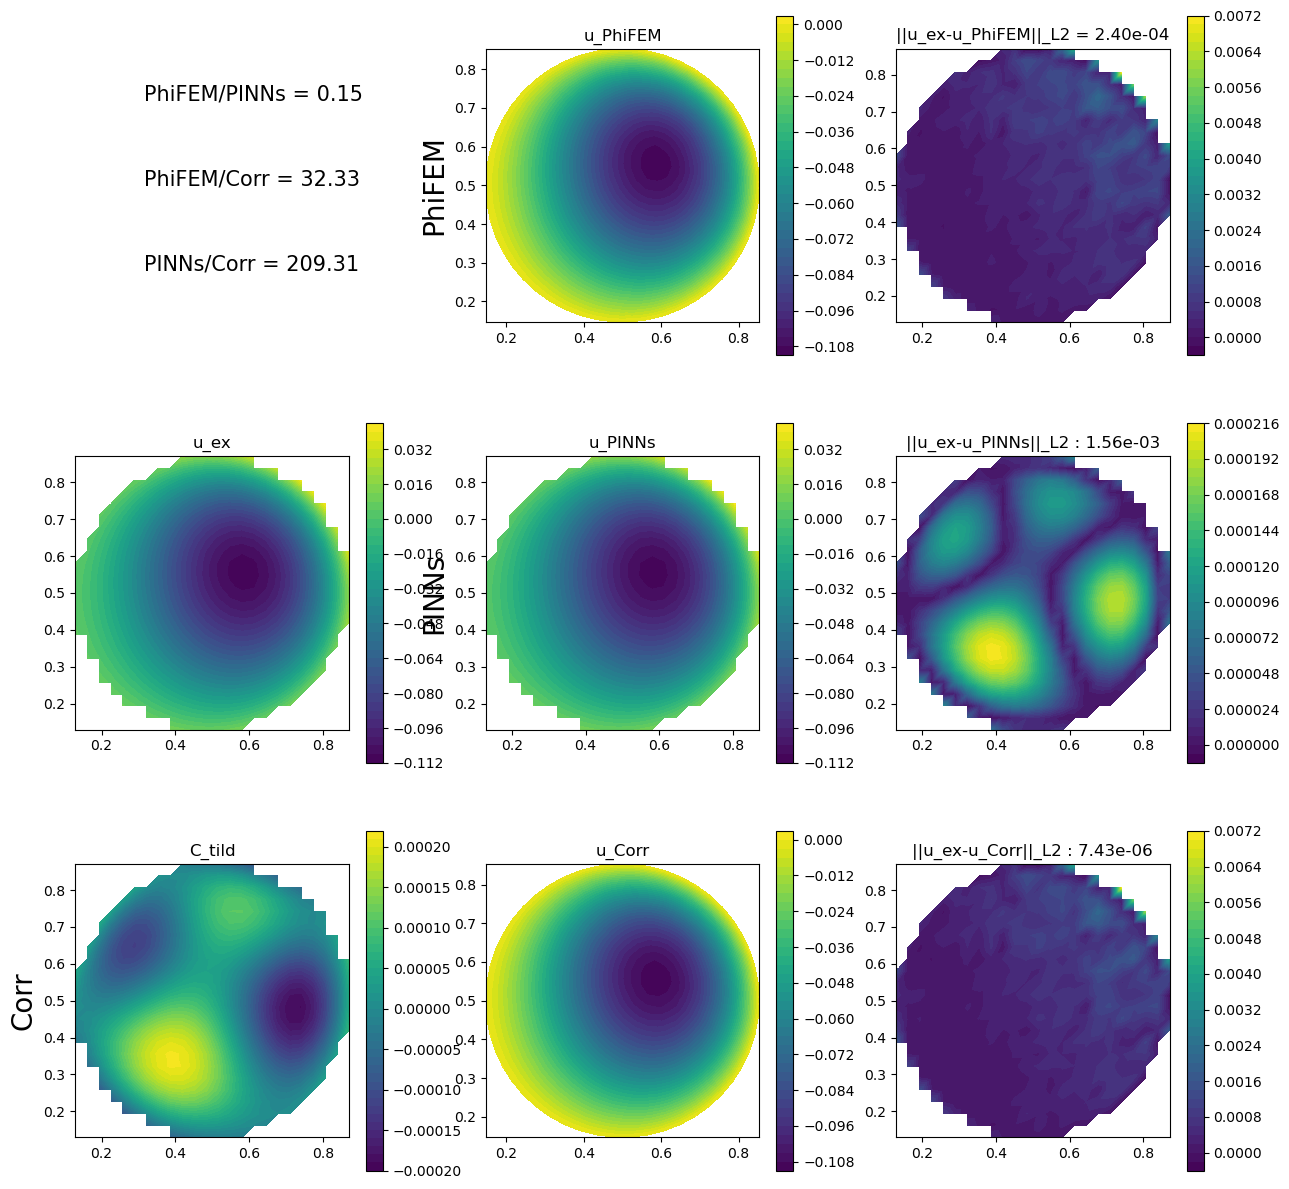

In [7]:
solver = PhiFemSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get differents solutions
u_ex = UexExpr(solver.params[0], degree=deg_corr, domain=solver.mesh, pb_considered=solver.pb_considered)
u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr, get_error=True)
u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type)
u_FEM,norm_L2_FEM = solver.fem(0)

# plot
u_ex = project(u_ex, solver.V)

solutions = [u_PINNs,u_Corr,u_FEM]
normes = [norm_L2_PINNs,norm_L2_Corr,norm_L2_FEM]

plot_sol(corr_dir,config,"PhiFEM",u_ex,C,solutions,normes,solver.V)

Projection sur $\Omega$ :

In [8]:
# # project u_ex on Omega
# u_ex_Omega = project(u_ex, solver.V_ex)

# # project u_Corr on Omega
# u_Corr_ = project(u_Corr, solver.V)
# u_Corr_Omega = project(u_Corr_, solver.V_ex)    
# norm_L2_Corr_Omega = (assemble((((u_ex_Omega - u_Corr_Omega)) ** 2) * solver.dx_ex) ** (0.5)) / (assemble((((u_ex_Omega)) ** 2) * solver.dx_ex) ** (0.5))

# # project u_FEM on Omega
# u_FEM_ = project(u_FEM, solver.V)
# u_FEM_Omega = project(u_FEM_, solver.V_ex)

# norm_L2_FEM_Omega = (assemble((((u_ex_Omega - u_FEM_Omega)) ** 2) * solver.dx_ex) ** (0.5)) / (assemble((((u_ex_Omega)) ** 2) * solver.dx_ex) ** (0.5))


# #####
# # Plot !
# #####

# solutions = [u_Corr_Omega,u_FEM_Omega]
# normes = [norm_L2_Corr_Omega,norm_L2_FEM_Omega]
# plot_sol(corr_type,"PhiFEM",u_ex_Omega,solutions,normes,solver.V_ex,project_on_Omega=True)
